In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from datasets import load_dataset
from tqdm import tqdm
from transformers import BertTokenizer
import torch.backends.cudnn as cudnn
import gensim.downloader as api
import math
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torch.cuda.amp import autocast, GradScaler

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
raw_dataset = load_dataset("tiny_shakespeare")
raw_dataset["train"]["text"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.10k [00:00<?, ?B/s]

tiny_shakespeare.py:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

The repository for tiny_shakespeare contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tiny_shakespeare.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

["First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger

In [6]:
train_text_list = raw_dataset["train"]["text"]  # large list of lines (strings)

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

full_text = "\n".join(train_text_list)  # combine everything
encoded_ids = tokenizer(full_text, add_special_tokens=False)['input_ids']  # encode text
vocab_size = len(tokenizer.vocab)

print("Total number of tokens:", len(encoded_ids))
print("Vocabulary size (from tokenizer):", vocab_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (258333 > 512). Running this sequence through the model will result in indexing errors


Total number of tokens: 258333
Vocabulary size (from tokenizer): 30522


In [8]:
split_idx = int(0.8 * len(encoded_ids))
train_ids = encoded_ids[:split_idx]
test_ids  = encoded_ids[split_idx:]

In [ ]:
class ShakespeareBPTTDataset(Dataset):
    """
    This dataset slices the token list into sequences of length `seq_length`,
    and the target is the next token.
    """
    def __init__(self, token_ids, seq_length=32):
        self.token_ids = token_ids
        self.seq_length = seq_length

    def __len__(self):
        return len(self.token_ids) - self.seq_length

    def __getitem__(self, idx):
        x = self.token_ids[idx : idx + self.seq_length]
        y = self.token_ids[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

In [10]:
SEQ_LENGTH = 32
train_dataset = ShakespeareBPTTDataset(train_ids, seq_length=SEQ_LENGTH)
test_dataset  = ShakespeareBPTTDataset(test_ids,  seq_length=SEQ_LENGTH)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size,num_workers=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, num_workers=16, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
class VanillaRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(VanillaRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Weights
        self.W_xh = nn.Parameter(torch.randn(input_size, hidden_size) * 0.01)
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.01)
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, h_prev):
        # x: (batch_size, input_size)
        # h_prev: (batch_size, hidden_size)
        # returns h_t: (batch_size, hidden_size)
        h_t = torch.tanh(x @ self.W_xh + h_prev @ self.W_hh + self.b_h)
        return h_t

In [ ]:
class StackedVanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.2):
        super(StackedVanillaRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.cells = nn.ModuleList()
        for layer in range(num_layers):
            in_size = input_size if layer == 0 else hidden_size
            self.cells.append(VanillaRNNCell(in_size, hidden_size))

        self.dropout = nn.Dropout(dropout)  # applied between layers

    def forward(self, x, hidden=None):
        """
        x shape: (batch_size, input_size)
        hidden: list/tuple of hidden states for each layer
        returns: output, new_hidden
        """
        if hidden is None:
            hidden = [torch.zeros(x.size(0), self.hidden_size, device=x.device)
                      for _ in range(self.num_layers)]

        new_hidden = []
        current_input = x

        for layer_idx, cell in enumerate(self.cells):
            h_prev = hidden[layer_idx]
            h_t = cell(current_input, h_prev)
            # Dropout on the output of each layer - just not final
            if layer_idx < self.num_layers - 1:
                h_t = self.dropout(h_t)
            new_hidden.append(h_t)

            current_input = h_t  # feed forward to next layer

        return current_input, new_hidden


In [ ]:
class StackedVanillaRNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=128,
                 num_layers=2, dropout=0.2):
        super(StackedVanillaRNNModel, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = StackedVanillaRNN(embed_size, hidden_size,
                                     num_layers=num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, hidden=None):
        """
        x: (batch_size, seq_length)
        hidden: list of hidden states for each layer
        Return: (logits, new_hidden)
          logits: (batch_size, seq_length, vocab_size)
        """
        batch_size, seq_length = x.shape
        if hidden is None:
            hidden = [torch.zeros(batch_size, self.hidden_size, device=x.device)
                      for _ in range(self.num_layers)]

        outputs = []
        new_hidden = hidden

        for t in range(seq_length):
            # Embed current token
            x_t = self.embed(x[:, t])  # shape: (batch_size, embed_size)
            out, new_hidden = self.rnn(x_t, new_hidden)  # out: (batch_size, hidden_size)
            # Projecting to vocab
            logits_t = self.fc(out)  # (batch_size, vocab_size)
            outputs.append(logits_t.unsqueeze(1))  # keep time dimension

        # Concatenate time dimension
        logits = torch.cat(outputs, dim=1)  # (batch_size, seq_length, vocab_size)
        return logits, new_hidden


In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device,
                    clip=5.0, scheduled_sampling_p=1.0):
    """
    scheduled_sampling_p: Probability of using ground-truth token.
    """
    model.train()
    total_loss = 0.0

    for x_batch, y_batch in tqdm(dataloader, leave=False):
        x_batch = x_batch.to(device)  # (batch_size, seq_length)
        y_batch = y_batch.to(device)  # (batch_size)

        batch_size, seq_length = x_batch.shape

        # We do a manual unroll with scheduled sampling:
        hidden = [torch.zeros(batch_size, model.hidden_size, device=device)
                  for _ in range(model.num_layers)]

        optimizer.zero_grad()

        outputs = []
        for t in range(seq_length):
            if t == 0:
                x_t_embed = model.embed(x_batch[:, t])
            else:
                #decide if we use ground truth or model's predicted token
                use_ground_truth = (random.random() < scheduled_sampling_p)
                if use_ground_truth:
                    input_token = x_batch[:, t]
                else:
                    # model's previous prediction
                    input_token = preds.argmax(dim=-1)  # from the last time step

                x_t_embed = model.embed(input_token)

            out, hidden = model.rnn(x_t_embed, hidden)
            preds = model.fc(out)  # (batch_size, vocab_size)
            outputs.append(preds.unsqueeze(1))

        logits = torch.cat(outputs, dim=1)
        last_logits = logits[:, -1, :]  
        loss = criterion(last_logits, y_batch)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            logits, _ = model(x_batch)

            last_logits = logits[:, -1, :]
            loss = criterion(last_logits, y_batch)
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
model = StackedVanillaRNNModel(
    vocab_size=vocab_size,
    embed_size=300, 
    hidden_size=256,
    num_layers=2,
    dropout=0.2
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # weight decay for regularization

In [ ]:
w2v_model = api.load("word2vec-google-news-300")

embedding_matrix = np.zeros((vocab_size, 300))
for word, idx in tokenizer.vocab.items():
    if word in w2v_model:
        embedding_matrix[idx] = w2v_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(300,))

model.embed.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float))


[==================================================] 100.0% 1662.8/1662.8MB downloaded


tensor([[ 0.1829, -0.2545, -0.1284,  ...,  0.0493, -1.1779,  0.7667],
        [ 1.2679,  0.5202,  0.5321,  ...,  0.3601, -0.3631,  0.6458],
        [-0.4694, -0.5146,  0.0429,  ...,  1.0233, -0.3620, -0.2334],
        ...,
        [-0.9804,  0.1735,  0.5338,  ...,  0.5423, -0.0126, -0.5002],
        [-0.3754, -0.5260,  0.0778,  ...,  0.5193, -0.2445,  0.1239],
        [ 1.4002,  0.2158,  0.0789,  ..., -0.2024, -0.0911, -0.0304]],
       device='cuda:0')

In [ ]:
cudnn.benchmark = True

In [ ]:
num_epochs = 5
p_start = 1.0 
p_end = 0.5    
clip = 5.0

In [26]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


scaler = GradScaler()

<ipython-input-26-7044f99f2a04>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scaler = GradScaler()

num_epochs = 5
p_start = 1.0  
p_end = 0.5    
clip = 5.0

train_losses_per_epoch = []
val_losses_per_epoch = []

for epoch in range(num_epochs):
    scheduled_sampling_p = p_start - (p_start - p_end) * (epoch / (num_epochs - 1))

    model.train()
    total_loss = 0
    count_samples = 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for x_batch, y_batch in train_loop:
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device) 

        optimizer.zero_grad()

        with autocast():
            hidden = [torch.zeros(x_batch.size(0), model.hidden_size, device=device)
                      for _ in range(model.num_layers)]

            outputs = []
            preds = None 
            for t in range(x_batch.size(1)):
                if t == 0:
                    x_t_embed = model.embed(x_batch[:, t])
                else:
                    use_ground_truth = (torch.rand(1).item() < scheduled_sampling_p)
                    if use_ground_truth:
                        input_token = x_batch[:, t]
                    else:
                        input_token = preds.argmax(dim=-1)  
                    x_t_embed = model.embed(input_token)

                out, hidden = model.rnn(x_t_embed, hidden)
                preds = model.fc(out) 
                outputs.append(preds.unsqueeze(1))

            logits = torch.cat(outputs, dim=1)
            last_logits = logits[:, -1, :]
            loss = criterion(last_logits, y_batch)

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x_batch.size(0)
        count_samples += x_batch.size(0)

    train_loss = total_loss / count_samples

    model.eval()
    total_val_loss = 0
    val_count = 0

    val_loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad(), autocast():
        for x_val, y_val in val_loop:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            logits, _ = model(x_val)
            last_logits = logits[:, -1, :]
            loss_v = criterion(last_logits, y_val)
            total_val_loss += loss_v.item() * x_val.size(0)
            val_count += x_val.size(0)

    val_loss = total_val_loss / val_count

    train_losses_per_epoch.append(train_loss)
    val_losses_per_epoch.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Scheduled Sampling p: {scheduled_sampling_p:.3f}")



<ipython-input-27-2bf9034e92e9>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/5 [Train]:   0%|          | 0/404 [00:00<?, ?it/s]<ipython-input-27-2bf9034e92e9>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/5 [Val]:   0%|          | 0/101 [00:00<?, ?it/s]<ipython-input-27-2bf9034e92e9>:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 1/5 | Train Loss: 6.7207 | Val Loss: 6.7846 | Scheduled Sampling p: 1.000


Epoch 2/5 [Train]: 100%|██████████| 404/404 [00:22<00:00, 18.08it/s]


Epoch 2/5 | Train Loss: 6.8504 | Val Loss: 6.4654 | Scheduled Sampling p: 0.875


Epoch 3/5 [Train]: 100%|██████████| 404/404 [00:21<00:00, 18.51it/s]


Epoch 3/5 | Train Loss: 6.1575 | Val Loss: 6.2789 | Scheduled Sampling p: 0.750


Epoch 4/5 [Train]: 100%|██████████| 404/404 [00:22<00:00, 17.99it/s]


Epoch 4/5 | Train Loss: 6.0202 | Val Loss: 6.0882 | Scheduled Sampling p: 0.625


Epoch 5/5 [Train]: 100%|██████████| 404/404 [00:21<00:00, 18.68it/s]
                                                                 

Epoch 5/5 | Train Loss: 5.9193 | Val Loss: 5.9284 | Scheduled Sampling p: 0.500


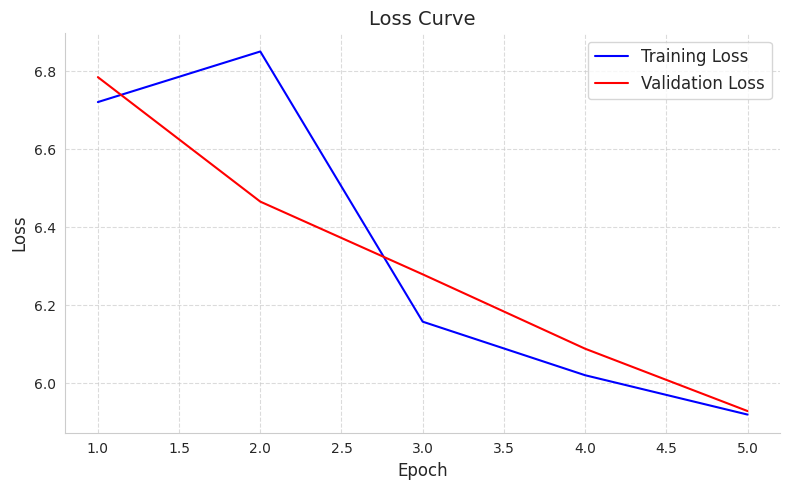

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
epochs = range(1, num_epochs + 1)

sns.lineplot(x=epochs, y=train_losses_per_epoch, label='Training Loss', color='blue')
sns.lineplot(x=epochs, y=val_losses_per_epoch, label='Validation Loss', color='red')


plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curve', fontsize=14)
plt.legend(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

sns.despine()

plt.tight_layout()
plt.show()

In [ ]:
def generate_text(
    model,
    prompt_text,  
    tokenizer,    
    max_new_tokens=20,
    temperature=1.0
):
    model.eval()

    if isinstance(prompt_text, str):
        prompt_tokens = tokenizer.encode(prompt_text, add_special_tokens=False)
    else:
        prompt_tokens = list(prompt_text)

    prompt_tokens = torch.tensor([prompt_tokens], dtype=torch.long, device=device)
    generated = prompt_tokens.squeeze(0).tolist()

    hidden = [torch.zeros(1, model.hidden_size, device=device)
              for _ in range(model.num_layers)]

    with torch.no_grad():
        for t in range(prompt_tokens.size(1) - 1):
            x_t = prompt_tokens[:, t]
            x_embed = model.embed(x_t)
            _, hidden = model.rnn(x_embed, hidden)

    current_token = prompt_tokens[:, -1]

    for _ in range(max_new_tokens):
        with torch.no_grad():
            x_embed = model.embed(current_token)
            out, hidden = model.rnn(x_embed, hidden)
            logits = model.fc(out)
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1).squeeze().cpu().numpy()
            next_token_id = np.random.choice(len(probs), p=probs)
            generated.append(next_token_id)
            current_token = torch.tensor([[next_token_id]], device=device)

    generated_text = tokenizer.decode(generated, skip_special_tokens=True)
    return generated_text

seed_text = "To be or not to"
output = generate_text(model, seed_text, tokenizer, max_new_tokens=20, temperature=0.6)
print(output)


to be or not tooffen, now to be it'd for the, and it is his discontent. d,


In [ ]:
def evaluate_and_perplexity(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_count = 0  # number of tokens predicted

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)  # (batch_size, seq_length)
            y_batch = y_batch.to(device)  # (batch_size)

            logits, _ = model(x_batch)

  
            last_logits = logits[:, -1, :]  # [batch_size, vocab_size]

            # Compute cross-entropy
            loss = criterion(last_logits, y_batch)

            batch_size = x_batch.size(0)
            total_loss += loss.item() * batch_size
            total_count += batch_size

    avg_loss = total_loss / total_count
    ppl = math.exp(avg_loss)  # perplexity = exp(cross-entropy)
    return avg_loss, ppl


In [31]:
test_loss, test_ppl = evaluate_and_perplexity(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Perplexity: {test_ppl:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Loss: 5.9284 | Test Perplexity: 375.5417


In [ ]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            logits, _ = model(x_batch)
            last_logits = logits[:, -1, :]
            predictions = torch.argmax(last_logits, dim=-1)  

            correct += (predictions == y_batch).sum().item()
            total   += y_batch.size(0)

    return correct / total  


In [33]:
test_acc = evaluate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.1247


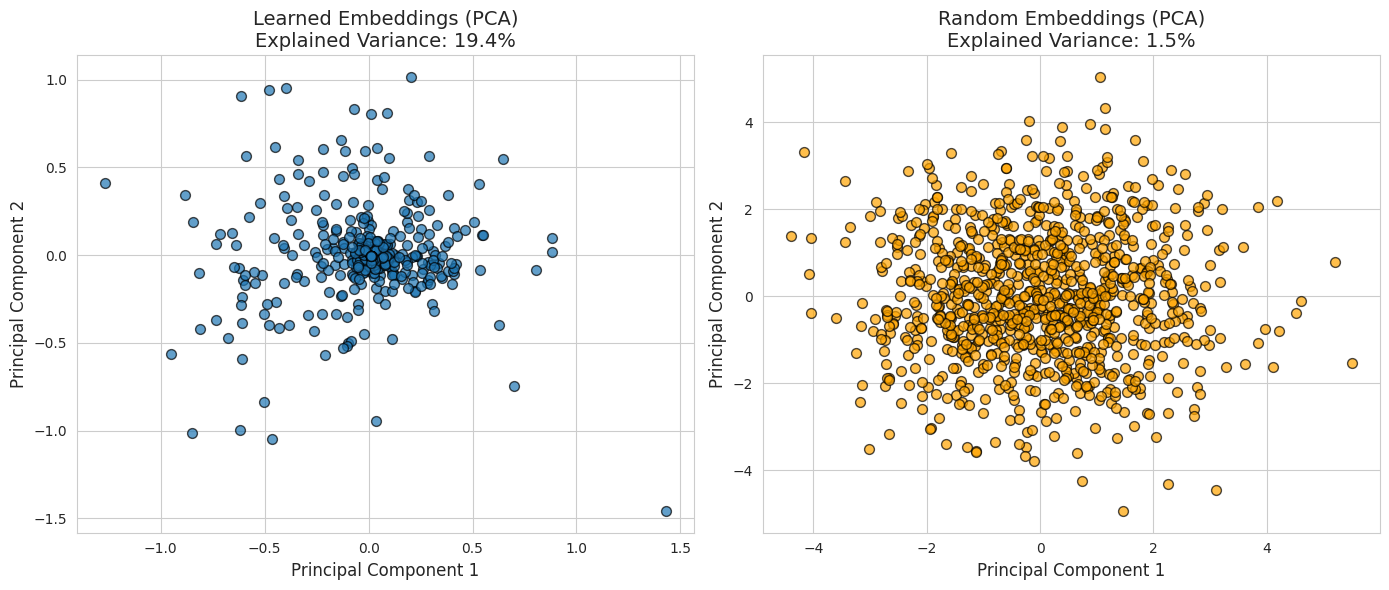

In [ ]:
learned_embeddings = model.embed.weight.data.cpu().numpy()

random_embeddings = torch.randn_like(model.embed.weight.data).cpu().numpy()

num_samples = 1000  
indices = np.random.choice(learned_embeddings.shape[0], size=num_samples, replace=False)
learned_subset = learned_embeddings[indices]
random_subset  = random_embeddings[indices]

pca_learned = PCA(n_components=2)
learned_pca = pca_learned.fit_transform(learned_subset)
explained_variance_learned = np.sum(pca_learned.explained_variance_ratio_) * 100

pca_random = PCA(n_components=2)
random_pca = pca_random.fit_transform(random_subset)
explained_variance_random = np.sum(pca_random.explained_variance_ratio_) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(learned_pca[:, 0], learned_pca[:, 1],
                alpha=0.7, edgecolors='k', s=50)
axes[0].set_title(f'Learned Embeddings (PCA)\nExplained Variance: {explained_variance_learned:.1f}%', fontsize=14)
axes[0].set_xlabel('Principal Component 1', fontsize=12)
axes[0].set_ylabel('Principal Component 2', fontsize=12)

axes[1].scatter(random_pca[:, 0], random_pca[:, 1],
                alpha=0.7, color='orange', edgecolors='k', s=50)
axes[1].set_title(f'Random Embeddings (PCA)\nExplained Variance: {explained_variance_random:.1f}%', fontsize=14)
axes[1].set_xlabel('Principal Component 1', fontsize=12)
axes[1].set_ylabel('Principal Component 2', fontsize=12)

plt.tight_layout()
plt.show()
